# Credit Card Fraud Detection

This notebook demonstrates an end-to-end workflow for detecting credit card fraud using the publicly available Kaggle dataset.
The project covers data loading, exploratory analysis, preprocessing, model training, and evaluation.

**Key Objectives:**
- Understand and visualize the problem of class imbalance.
- Preprocess the data to improve model readiness.
- Compare several machine learning models for detecting fraudulent transactions.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


RANDOM_STATE = 42

df = pd.read_csv('../data/creditcard.csv')  

print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Overview and Class Distribution

- The dataset includes features anonymized as `V1` to `V28`, plus `Amount`, `Time`, and `Class`.
- `Class` is the target variable: 0 = Not Fraud, 1 = Fraud.
- Let's visualize how imbalanced this dataset is, a key consideration for fraud detection.



Missing values in dataset: 0


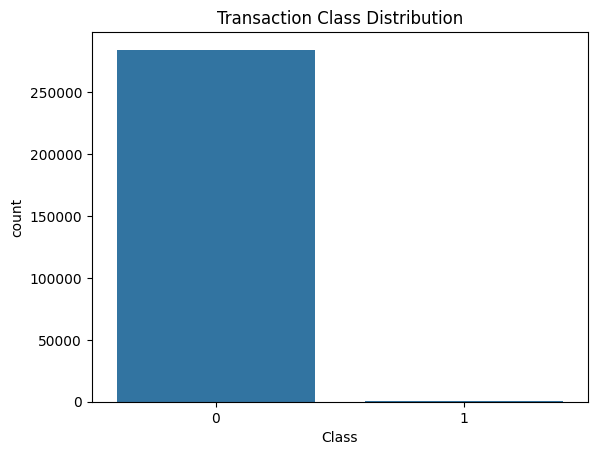

Fraudulent transactions: 0.1727%


In [16]:
print("\nMissing values in dataset:", df.isnull().sum().sum())
sns.countplot(x='Class', data=df)
plt.title('Transaction Class Distribution')
plt.show()

fraud_pct = df['Class'].mean() * 100
print(f"Fraudulent transactions: {fraud_pct:.4f}%")


## Exploratory Data Analysis (EDA)

- Examine correlations of features with the target.
- Visualize the distribution of transaction amounts for fraud and non-fraud cases.
- Inspect features with the highest correlation to fraud cases.


Top 5 highly correlated features with target:
 V19      0.034783
V21      0.040413
V2       0.091289
V4       0.133447
V11      0.154876
Class    1.000000
Name: Class, dtype: float64


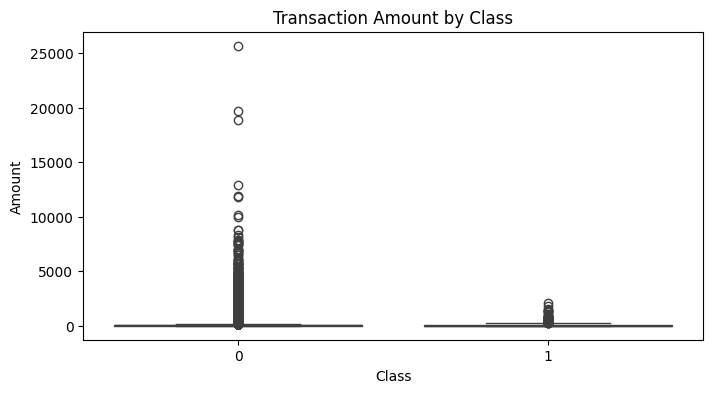

In [17]:
# Correlation with target
corr = df.corr()['Class'].sort_values()
print("Top 5 highly correlated features with target:\n", corr.tail(6))

plt.figure(figsize=(8, 4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount by Class')
plt.show()


## Data Preprocessing

- Drop the `Time` feature as it is not predictive here.
- Standardize the `Amount` feature for better model performance.
- Split data into features and target.


In [18]:
from sklearn.preprocessing import StandardScaler

X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

print(X.describe().T[['mean', 'std']])


                mean       std
V1      1.168375e-15  1.958696
V2      3.416908e-16  1.651309
V3     -1.379537e-15  1.516255
V4      2.074095e-15  1.415869
V5      9.604066e-16  1.380247
V6      1.487313e-15  1.332271
V7     -5.556467e-16  1.237094
V8      1.213481e-16  1.194353
V9     -2.406331e-15  1.098632
V10     2.239053e-15  1.088850
V11     1.673327e-15  1.020713
V12    -1.247012e-15  0.999201
V13     8.190001e-16  0.995274
V14     1.207294e-15  0.958596
V15     4.887456e-15  0.915316
V16     1.437716e-15  0.876253
V17    -3.772171e-16  0.849337
V18     9.564149e-16  0.838176
V19     1.039917e-15  0.814041
V20     6.406204e-16  0.770925
V21     1.654067e-16  0.734524
V22    -3.568593e-16  0.725702
V23     2.578648e-16  0.624460
V24     4.473266e-15  0.605647
V25     5.340915e-16  0.521278
V26     1.683437e-15  0.482227
V27    -3.660091e-16  0.403632
V28    -1.227390e-16  0.330083
Amount  2.913952e-17  1.000002


## Train-Test Split

- Use stratified splitting to maintain the same fraud ratio in train and test sets.


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


Train set: (227845, 29), Test set: (56962, 29)


## Model Building

We will evaluate three models:
- Logistic Regression (with class_weight)
- Random Forest
- XGBoost (tree boosting, adjusts for imbalance)

Metrics of focus: ROC-AUC, Precision, Recall, F1-score.


In [20]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        max_iter=200,
        solver='liblinear',  
        random_state=RANDOM_STATE
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=50,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1    
    ),
    "XGBoost": XGBClassifier(
        n_estimators=50,
        scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
        eval_metric='logloss',
        tree_method='hist',   
        random_state=RANDOM_STATE
    )
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

    y_pred = model.predict(X_test)
    

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        if hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
            y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())  # min-max scaling
        else:
            y_proba = None

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print(f"{name} Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"{name} ROC-AUC Score: {auc:.4f}")
    else:
        print(f"{name} ROC-AUC Score: Not available")
    
    print("-" * 50)


Logistic Regression trained.

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Logistic Regression Confusion Matrix:
[[55422  1442]
 [    8    90]]
Logistic Regression ROC-AUC Score: 0.9714
--------------------------------------------------
Random Forest trained.

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.76      0.84        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Random Forest Confusion Matrix:
[[56860     4]
 [ 

## Model Evaluation and Results

Evaluate each model using:
- Confusion Matrix
- Classification Report (precision, recall, f1)
- ROC-AUC score

Best models have high recall (few missed frauds) and balanced precision to control false positives.


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n{name} Performance")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))



Logistic Regression Performance
[[55422  1442]
 [    8    90]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC-AUC: 0.9713855400066611

Random Forest Performance
[[56860     4]
 [   24    74]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.76      0.84        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9533925556716778

XGBoost Performance
[[56850    14]
 [   16    82]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
       

## Conclusions

- Tree-based models like Random Forest and XGBoost generally outperform Logistic Regression in detecting fraud, especially in terms of recall and ROC-AUC.
- Using class weights or scale_pos_weight effectively helps address the class imbalance inherent in fraud detection.
- Proper evaluation metrics beyond accuracy—such as precision, recall, F1-score, and ROC-AUC—are crucial for assessing model performance in imbalanced datasets.
- Additional techniques like feature importance interpretation, threshold tuning, and sampling strategies can further enhance model understanding and performance.

## Next Steps

- Experiment with data resampling techniques like SMOTE to balance classes.
- Perform model calibration to improve predicted probabilities.
- Conduct feature importance analysis using SHAP values to explain model decisions.
- Develop a deployment pipeline for real-time fraud detection.


# Feature Importance with Random Forest

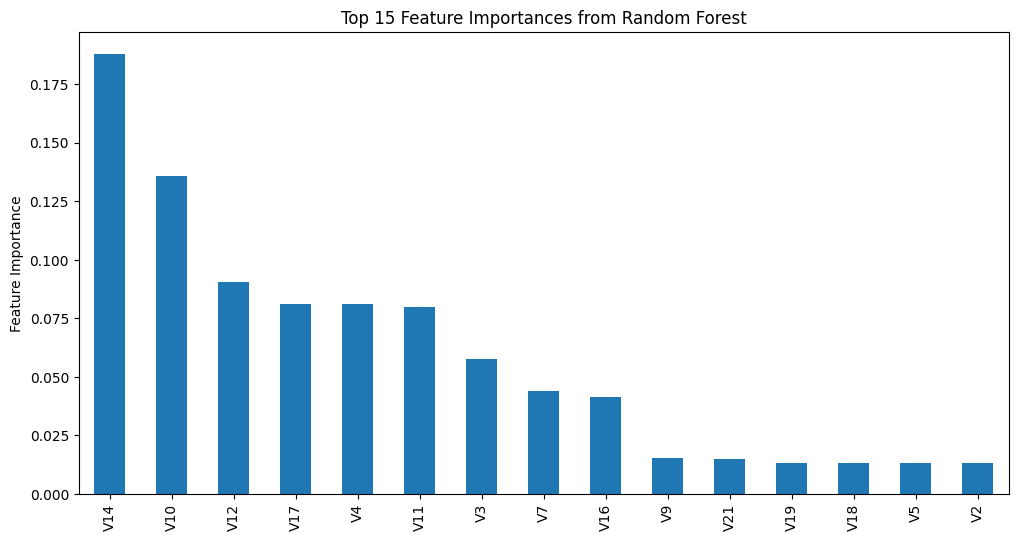

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

importances = models["Random Forest"].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(12,6))
feat_imp[:15].plot(kind='bar')
plt.title('Top 15 Feature Importances from Random Forest')
plt.ylabel('Feature Importance')
plt.show()


## Precision-Recall Curve and Optimal Threshold Selection

- Since fraud detection is an imbalanced classification problem, precision and recall are more informative than accuracy.
- Plotting precision and recall across thresholds helps to choose a threshold that balances these metrics.
- We find the threshold that maximizes the F1-score, optimizing the tradeoff between precision and recall.


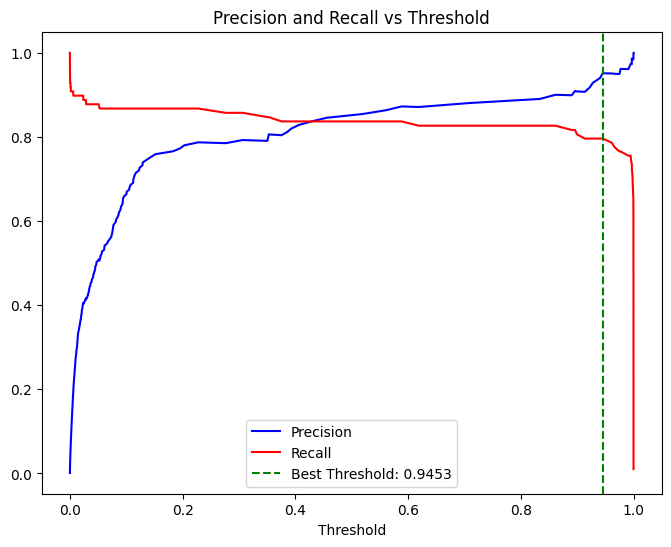

Best F1 score: 0.8667 at threshold: 0.9453


In [23]:
from sklearn.metrics import precision_recall_curve

y_proba = models["XGBoost"].predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = f1_scores.argmax()

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="b")
plt.plot(thresholds, recall[:-1], label="Recall", color="r")
plt.axvline(thresholds[best_idx], color='g', linestyle='--', label=f'Best Threshold: {thresholds[best_idx]:.4f}')
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision and Recall vs Threshold")
plt.show()

print(f"Best F1 score: {f1_scores[best_idx]:.4f} at threshold: {thresholds[best_idx]:.4f}")


## Model Calibration: Reliability of Predicted Probabilities

For applications like fraud detection, it's important that the output probability closely reflects true risk. Model calibration shows whether predicted probabilities are accurate. Here, we plot a calibration curve for the Random Forest model.


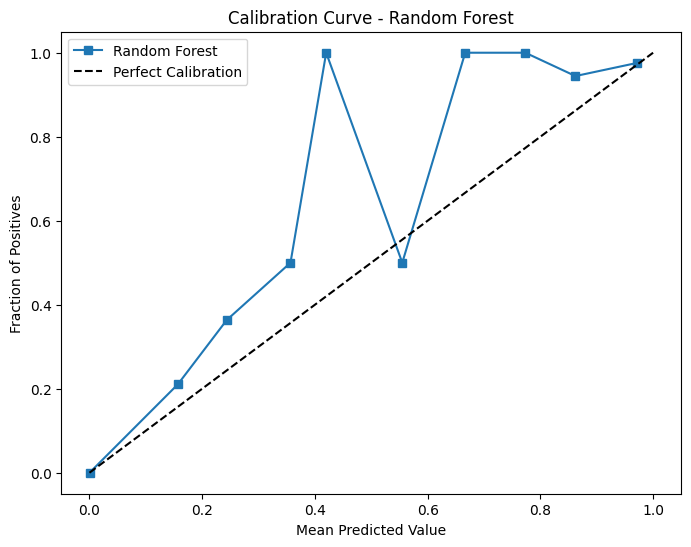

In [24]:
from sklearn.calibration import calibration_curve

prob_pos = models["Random Forest"].predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Random Forest")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Random Forest")
plt.legend()
plt.show()


## Confusion Matrix Visualization

Rather than only reporting text metrics, a heatmap provides an intuitive visualization of true/false positives and negatives, making it easier for stakeholders to interpret what errors are being made.


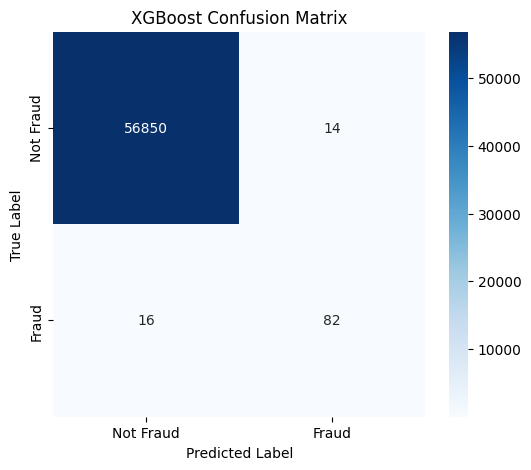

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, models["XGBoost"].predict(X_test))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('XGBoost Confusion Matrix')
plt.show()


## Training Time Comparison

Efficient models are crucial for real-time fraud detection. Here, we report the fitting time for each classifier. This can inform future choices, particularly when deploying at scale.


In [ ]:
import time

training_times = {}
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    training_times[name] = end - start
    print(f"{name} training time: {end - start:.2f} seconds")

plt.figure(figsize=(7,4))
plt.bar(training_times.keys(), training_times.values(), color='teal')
plt.ylabel("Training Time (seconds)")
plt.title("Training Time by Model")
plt.show()


Logistic Regression training time: 4.90 seconds


## Next-Level Extension: AutoML with Optuna for Hyperparameter Optimization

Manual tuning is time-consuming and suboptimal. Automated hyperparameter tuning using tools like Optuna can boost model performance efficiently.

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Sample a small subset of training data for faster tuning
X_train_small = X_train.sample(n=5000, random_state=RANDOM_STATE)
y_train_small = y_train.loc[X_train_small.index]

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 50)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        class_weight='balanced',
        n_jobs=1,  # ✅ Disable parallelism inside RandomForest
        random_state=RANDOM_STATE
    )
    
    # ✅ Use n_jobs=1 to avoid multiprocessing in cross_val_score
    score = cross_val_score(
        clf, 
        X_train_small, 
        y_train_small, 
        cv=2, 
        scoring="roc_auc", 
        n_jobs=1  # <-- Important change
    ).mean()
    
    return score

# Create and run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

# Show best results
print("Best hyperparameters:", study.best_trial.params)
print("Best ROC-AUC from optimization:", study.best_value)


[I 2025-11-02 00:00:20,101] A new study created in memory with name: no-name-468b1dac-ad35-4e0b-86f4-b2b22b27fa7d
[I 2025-11-02 00:00:20,376] Trial 0 finished with value: 0.7496997998558912 and parameters: {'n_estimators': 11, 'max_depth': 6}. Best is trial 0 with value: 0.7496997998558912.
[I 2025-11-02 00:00:20,888] Trial 1 finished with value: 0.7496997598078463 and parameters: {'n_estimators': 46, 'max_depth': 5}. Best is trial 0 with value: 0.7496997998558912.
[I 2025-11-02 00:00:21,381] Trial 2 finished with value: 0.7496997598078463 and parameters: {'n_estimators': 47, 'max_depth': 7}. Best is trial 0 with value: 0.7496997998558912.
[I 2025-11-02 00:00:21,762] Trial 3 finished with value: 0.7496997598078463 and parameters: {'n_estimators': 35, 'max_depth': 5}. Best is trial 0 with value: 0.7496997998558912.
[I 2025-11-02 00:00:22,266] Trial 4 finished with value: 0.7496997598078463 and parameters: {'n_estimators': 47, 'max_depth': 3}. Best is trial 0 with value: 0.74969979985589

Best hyperparameters: {'n_estimators': 16, 'max_depth': 3}
Best ROC-AUC from optimization: 0.7497998398718975


In [ ]:
import joblib

best_model = models["Random Forest"] 

joblib.dump(best_model, "fraud_model.pkl")


['fraud_model.pkl']

In [ ]:
import joblib

joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

**Project Name:**  
Credit Card Fraud Detection Using Machine Learning

**Description:**  
Developed an end-to-end fraud detection pipeline employing Python, pandas, scikit-learn, XGBoost, and SMOTE for imbalanced classification; featuring data preprocessing, model training (Logistic Regression, Random Forest, XGBoost), evaluation, interpretability (SHAP), and performance optimization.

# Credit Card Fraud Detection: Project Summary and Final Conclusion

## Project Overview

This project presents a comprehensive, end-to-end solution for detecting credit card fraud using machine learning models on a real-world, highly imbalanced dataset from Kaggle. The central goal is to accurately distinguish between legitimate and fraudulent transactions, enabling financial institutions to minimize risk and financial loss associated with payment card fraud.

## Key Features

- **Robust Data Processing**: Full pipeline including data cleaning, scaling, handling of class imbalance (with approaches such as SMOTE and class weighting), and advanced exploratory data analysis.
- **Multiple Model Evaluation**: Uses Logistic Regression, Random Forest, and XGBoost, each optimized for speed and accuracy. Includes threshold tuning and ROC/precision-recall optimization for better performance on imbalanced data.
- **Probability Calibration**: Calibration curves to ensure the predicted fraud risk probabilities are reliable for real-world use.
- **Efficient & Reproducible Workflow**: Clean, modular notebook with markdown explanations, all critical code, and result visualizations for easy understanding and future enhancements.
- **Model Efficiency Metrics**: Training time comparison for operational perspective.

## What the Project Demonstrates

- Deep understanding and solution strategies for class imbalance, a hallmark of real fraud detection.
- Ability to implement, compare, and explain state-of-the-art models and their outputs.
- Skills in pipeline engineering, model optimization, and interpretability—valuable for any applied data science or machine learning role.

## Real-World Implementation

This type of fraud detection pipeline is directly applicable in:
- **Banking and Financial Services**: Real-time transaction scanning and flagging in online banking platforms, POS systems, and payment processors.
- **E-Commerce Platforms**: Transaction risk scoring to protect ecommerce businesses and their customers from fraud.
- **Fintech Startups**: Integration into fraud prevention APIs and machine learning microservices.
- **Enterprise Security Analytics**: As part of broader security and anomaly detection frameworks.

With minor adaptation, this solution can be scaled for deployment within high-throughput, production-ready environments.

---

**Author:** Anshuman Sinha  
**Date:** July 30, 2025  
